# 1 Solving a contextual knapsack problem
In this notebook we shortly introduce Decision-Focused Learning, and how it can be applied to a contextual knapsack problem. With this, we present the basic structure of PyDFLT.

In [1]:
import os
import sys

path_to_project = os.path.dirname(os.path.abspath("")) + "/"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("PyDFLT"))))

## 1.0 Introduction to Decision-Focused Learning (DFL)
DFL aims at learning a predictive model that maximizes the decision quality of a downstream decision-making task or optimization model. This problem as a whole is named a predict & optimize or contextual optimization problem. In this setting, the optimization model has some uncertain parameters that correlate with some context or features. If seen as a pure predictive problem, one could aim to maximize predictive accuracy. However, since we know we will use the predictions to make decisions, we aim at maximizing decision quality. To do this, PyDFLT is based on a general structure including the following components:

1. An `OptimizationModel` which specifies the optimization model/decision-making task we try to tackle, including some uncertain parameters
2. A `Dataset` which includes the training data, i.e., the context/feature values that correlate with the uncertain parameters
3. The `Problem` we are trying to solve, defined by the `Dataset` and `OptimizationModel`
4. A `DecisionMaker`, which includes the DFL approach that is used to learn the mapping from features to decisions. It includes a `Predictor` to  map from features to uncertain parameters, and a decision model to map from uncertain parameters to decisions.
5. A `Runner` which runs the training loop to train the `DecisionMaker` in making high-quality decisions.

We will show the usage of these components in this notebook, applied to a continuous knapsack problem.

## 1.1 The `OptimizationModel`
The optimization model is the formulation of the model that the decision maker wants to solve in practice. Given some realization of the uncertain parameters, solving the model will lead to a decision. Currently we support models defined as a differentiable model using CVXPY or models defined using gurobipy (including two-stage stochastic models). As an example we will take a continuous knapsack model.

A continuous knapsack model consists of a set of items with a value and a weight. The goal is to pick items such that you maximize the total value while adhering to the capacity constraint: the weights cannot exceed the capacity. In the continuous variant, you are allowed to pick partial items. This model is differentiable, which means we use *CVXPYLayers* [1] under the hood.

In [2]:
from src.concrete_models import CVXPYDiffKnapsackModel

num_items = 10
optimization_model = CVXPYDiffKnapsackModel(num_decisions=num_items, capacity=20, weights_lb=3, weights_ub=8, dimension=1, seed=5)

Auto-Sklearn cannot be imported.


## 1.2 The `Dataset`
For a DFL problem there is data required with feature and uncertain parameter pairs. The `Dataset` itself is created by the problem class, so the only requirement for the data is that it is in a `dict` that has a `'features'` key and a key for each uncertain parameters as defined in the `OptimizationModel`.

In [3]:
from src.generate_data_functions.generate_data_knapsack import gen_data_knapsack

print(f"Uncertain parameter names: {optimization_model.param_to_predict_names}.")
data = gen_data_knapsack(seed=5, num_data=2000, num_items=num_items, num_features=5)
print(f"Data dictionary keys: {data.keys()}.")

Uncertain parameter names: ['item_value'].
Data dictionary keys: dict_keys(['item_value', 'features']).


## 1.3 The `Problem`
A DFL problem is defined by an optimization model and data, so we can now define the problem. It also includes the train/validation/test ratios. Optimal decisions and objectives for the in data observed parameter realization are most efficiently computed upfront, which is one of the `Problem`'s settings. There are some other settings including not randomizing the split but keeping the data in (timely) order: `time_respecting_split`.

In [4]:
from src.problem import Problem

problem = Problem(
    data_dict=data,
    opt_model=optimization_model,
    train_ratio=0.7,
    val_ratio=0.15,
    compute_optimal_decisions=True,
    compute_optimal_objectives=True,
    time_respecting_split=False,
    seed=5,
)

Computing optimal decisions for the entire dataset...
Optimal decisions computed and added to dataset.
Computing optimal objectives for the entire dataset...
Optimal objectives computed and added to dataset.
Shuffling indices before splitting...
Dataset split completed: Train=1400, Validation=300, Test=300


## 1.4 The `DecisionMaker`
This is the object that maps from features to decisions, which is generally done using a `Predictor` that maps from features to uncertain parameters and a `decision_model` based on the defined `OptimizationModel` that maps from uncertain parameters to decisions. The `DecisionMaker` includes the method that is used to train itself and therefore always includes a `run_epoch` and an `update` method. The `DifferentiableDecisionMaker` uses differentiation. Training its `Predictor` to minimize mean squared error (Prediction-Focused Learning) for example can be done using this decision maker, but also using any differentiable surrogate losses implemented in *PyEPO* [2], or differentiating through the optimization model using *CVXPYLayers* [1] is possible. The other decision makers do not use direct differentiation, but for example use stochastic gradient estimation to differentiate. Our example problem is differentiable, so we use `'regret'` as loss function. As a predictor we use a linear predictor (Multi Layer Perceptron without hidden layers).

In [16]:
from src.decision_makers import DifferentiableDecisionMaker

decision_maker = DifferentiableDecisionMaker(
    problem=problem, learning_rate=1e-4, batch_size=32, loss_function_str="objective", predictor_str="MLP", predictor_kwargs={"num_hidden_layers": 0}, seed=5
)

Problem mode set to: train
Problem mode set to: train


## 1.5 The `Runner`
This object is used to train the `DecisionMaker`. It includes the number of epochs to run and also defines what are important metrics. When `save_best=True`, it stores the best performing model on the validation set, otherwise it just takes the model obtained after the last epoch.

In [17]:
from src.runner import Runner

runner = Runner(decision_maker=decision_maker, num_epochs=50, main_metric="objective", use_wandb=False, save_best=True, seed=5)
runner.run()

Epoch 0/50: Starting initial validation...
Problem mode set to: validation
Epoch Results:
validation/item_value_mean: 4.7995
validation/abs_regret_mean: 10.8777
validation/sym_rel_regret_mean: 0.2246
validation/objective_mean: 19.9607
validation/mse_mean: 60.4845
validation/select_item_mean: 0.3886
validation/rel_regret_mean: 0.3487
Initial best validation metric (objective): 19.960660934448242
Starting training...
Epoch: 1/50
Problem mode set to: train
Epoch Results:
train/grad_norm_mean: 0.0000
validation/item_value_mean: 4.7995
train/solver_calls_mean: 1019.8182
train/sym_rel_regret_mean: 0.2318
train/objective_mean: 18.1989
train/loss_mean: -18.1989
validation/abs_regret_mean: 10.8777
validation/sym_rel_regret_mean: 0.2246
validation/objective_mean: 19.9607
validation/mse_mean: 60.4845
validation/select_item_mean: 0.3886
validation/rel_regret_mean: 0.3487
train/rel_regret_mean: 0.3583
train/abs_regret_mean: 10.6234
Problem mode set to: validation
Epoch Results:
train/grad_norm_mean

np.float32(19.926155)

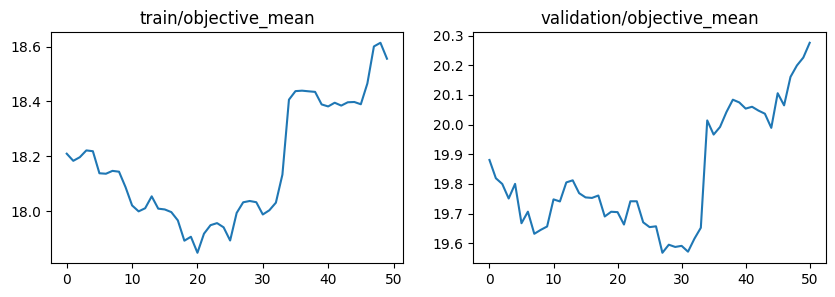

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metric = "train/objective_mean"
_ = axs[0].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[0].set_title(metric)

metric = "validation/objective_mean"
_ = axs[1].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[1].set_title(metric)

## References
[1] Akshay Agrawal, Brandon Amos, Shane Barratt, Stephen Boyd, Steven Diamond, and J Zico Kolter. Differentiable convex optimization layers. Advances in neural information processing systems, 32, 2019. doi:[10.48550/arXiv.1910.12430](https://doi.org/10.48550/arXiv.1910.12430).

[2] Bo Tang and Elias B. Khalil. Pyepo: a pytorch-based end-to-end predict-then-optimize library for linear and integer programming. Mathematical Programming Computation, 16(3):297–335, 2024. doi:[10.1007/s12532-024-00255-x](https://doi.org/10.48550/arXiv.1910.12430).